In [1]:
import tweepy
import time
import json
import random
import requests as req
import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [ ]:
last_replied_tweet = [None]

def SentimentTweet():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())
    
    request_user_list = []
    search_target_list = []
    sentiments = []
    
    my_tweets = api.mentions_timeline(since_id = last_replied_tweet[0])
    last_replied_tweet[0] = my_tweets[0]["id"]
    for tweet in my_tweets:
        #print(json.dumps(tweet, sort_keys=True, indent=4))
        try:
            if tweet["text"] == "@"+tweet["entities"]["user_mentions"][0]["screen_name"] +" Analyze @" + tweet["entities"]["user_mentions"][1]["screen_name"] and tweet["entities"]["user_mentions"][1]["screen_name"] not in search_target_list:
                search_target_list.append(tweet["entities"]["user_mentions"][1]["screen_name"])
                request_user_list.append(tweet["user"]["screen_name"])
                
            elif tweet["text"] == "@"+tweet["entities"]["user_mentions"][0]["screen_name"] +" Analyze @" + tweet["entities"]["user_mentions"][1]["screen_name"] and tweet["entities"]["user_mentions"][1]["screen_name"] in search_target_list:
                print(f'{tweet["entities"]["user_mentions"][1]["screen_name"]} has been analyzed,try someone else.')
            else:
                print(f'sorry {tweet["text"]} is not found')
        except:
            pass
    print(len(my_tweets))
    print(search_target_list)
    print(request_user_list)

    for target in search_target_list:
        counter =1
        oldest_tweet = None
        for x in range(25):
            public_tweets = api.user_timeline(target, max_id = oldest_tweet)
            for tweet in public_tweets:
                results = analyzer.polarity_scores(tweet["text"])
                compound = results["compound"]
                pos = results["pos"]
                neu = results["neu"]
                neg = results["neg"]
                tweets_ago = counter

                oldest_tweet = tweet['id'] - 1

                sentiments.append({"User": target,"Date": tweet["created_at"], 
                                "Compound": compound,"Positive": pos,
                                "Negative": neu,"Neutral": neg,
                                "Tweets Ago": counter}) 
                counter += 1

        sentiments_pd = pd.DataFrame.from_dict(sentiments)

        x_vals = sentiments_pd.loc[sentiments_pd["User"] == target]["Tweets Ago"]
        y_vals = sentiments_pd.loc[sentiments_pd["User"] == target]["Compound"]
        plt.plot(x_vals,y_vals, marker="o", linewidth=0.5,alpha=0.8)
        now = datetime.now()
        now = now.strftime("%Y-%m-%d %H:%M")
        plt.title(f"Sentiment Analysis of Tweets ({now}) for {target}")
        plt.xlim([x_vals.max(),x_vals.min()])
        plt.ylabel("Tweet Polarity")
        plt.xlabel("Tweets Ago")
        plt.savefig(f"Sentiment Analysis for {target}.png", bbox_inches='tight')
        plt.show()
        
    for i in range(len(request_user_list)):
        api.update_with_media(f'/Users/jingxu/Desktop/Homework_Jing/Homework-JingXu/07SocialAnalytics/PlotBot/Sentiment Analysis for {search_target_list[i]}.png',
                          f"New Tweet Analysis: @{search_target_list[i]} (Thx @{request_user_list[i]})")
        i+=1

sorry @JingXu35625367 @gdebenedetti is not found
5
['INCIndia', 'UN']
['fangpipila', 'fangpipila']


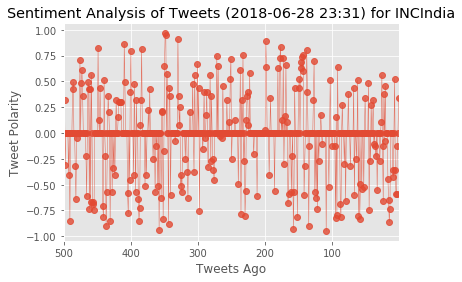

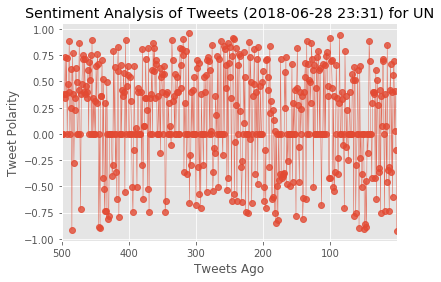

In [ ]:
while(True):
    SentimentTweet()
    time.sleep(30*60)